**Import Important Packages**

In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [ ]:
# data = pd.read_csv('kaggle_visible_evaluation_triplets.txt', sep="\t", header=None)
# data.columns = ["user_id", "song_id","frequency"]
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# data['user_id'] = le.fit_transform(data['user_id'])
# data['song_id'] = le.fit_transform(data['song_id'])
# data.to_csv('encdata.csv',index=False)

In [ ]:
data = pd.read_csv('encdata.csv')

data

,user_id,song_id,frequency
0,108811,10546,1
1,108811,28684,1
2,108811,36622,1
3,108811,51861,1
4,108811,24663,1
...,...,...,...
1450928,40490,136574,1
1450929,40490,134757,2
1450930,40490,11310,2
1450931,40490,80823,2


**Check for the duplicate records**

In [ ]:
data.duplicated(["song_id","user_id", "frequency"]).sum()

0

# Split Data into Train and Test Data

*   train_data = 80%
*   test_data = 20%


In [ ]:
n = len(data)
print(n)
train_data = data[:int(0.8*n)]
test_data = data[int(0.8*n):]
train_data.shape,test_data.shape

1450933


((1160746, 3), (290187, 3))

# Create User-Item Sparse Matrix

In User-Item sparse matrix, songs' values are present in the column and users' values are present in the rows. The frequency of the user is present in the cell.

In [ ]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.frequency, (df.user_id, df.song_id)))
    return sparse_data

**Create Sparse Matrix from the Training Dataset**

In [ ]:
train_sparse_data = get_user_item_sparse_matrix(train_data)

**Create Sparse Matrix from the Test Dataset**

In [ ]:
test_sparse_data = get_user_item_sparse_matrix(test_data)

**Find Average Gloabal Rating of song**

In [ ]:
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print("Global Average Rating: {}".format(global_average_rating))

Global Average Rating: 3.1815435935165834


**A Generic Method to Calculate Average Rating from Sparse Matrix**

In [ ]:
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1  
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1 
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings

**Calculate Average User Rating**

In [ ]:
average_rating_user = get_average_rating(train_sparse_data, True)
t = get_average_rating(test_sparse_data, True) 


**Calcualte Average song Rating**

In [ ]:
avg_rating_song = get_average_rating(train_sparse_data, False)
tm = get_average_rating(test_sparse_data, False)

In [ ]:
len(t),len(tm)

(22183, 77283)

# Check Cold Start Problem for Users

In [ ]:
total_users = len(np.unique(data["user_id"]))
train_users = len(average_rating_user)
uncommonUsers = total_users - train_users
                  
print("Total no. of Users = {}".format(total_users))
print("No. of Users in train data = {}".format(train_users))
print("No. of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. of Users = 110000
No. of Users in train data = 87818
No. of Users not present in train data = 22182(20.0%)


# Check Cold Start Problem for the songs


In [ ]:
total_songs = len(np.unique(data["song_id"]))
train_songs = len(avg_rating_song)
uncommonsongs = total_songs - train_songs
                  
print("Total no. of songs = {}".format(total_songs))
print("No. of songs in train data= {}".format(train_songs))
print("No. of songs not present in train data = {}({}%)".format(uncommonsongs, np.round((uncommonsongs/total_songs)*100), 2))

Total no. of songs = 163206
No. of songs in train data= 149088
No. of songs not present in train data = 14118(9.0%)


# Computation of user similarity to find similarities of top 100 users

In [ ]:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(8781800).reshape(87818,100)
    
    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar
    
    return similar_arr

In [ ]:
similar_user_matrix = compute_user_similarity(train_sparse_data, 100)

In [ ]:
similar_user_matrix[0]

array([0.05811155, 0.05839572, 0.05839572, 0.06019293, 0.06019293,
       0.06019293, 0.06082991, 0.06111957, 0.06165532, 0.06286946,
       0.0635963 , 0.06384424, 0.06573295, 0.06593805, 0.06593805,
       0.06593805, 0.06668313, 0.06747008, 0.06855912, 0.0695048 ,
       0.0695048 , 0.0695048 , 0.07125835, 0.07151985, 0.07151985,
       0.0725954 , 0.07372098, 0.07372098, 0.07449055, 0.07582342,
       0.0761387 , 0.07744031, 0.07800546, 0.07819291, 0.07881104,
       0.07881104, 0.07881104, 0.07916525, 0.07949538, 0.08178608,
       0.08178608, 0.08178608, 0.08340577, 0.08512565, 0.08512565,
       0.08780041, 0.08840993, 0.08840993, 0.08902332, 0.09006451,
       0.09028939, 0.09249845, 0.09325048, 0.09362574, 0.09567297,
       0.09567297, 0.09822191, 0.09829464, 0.09890707, 0.10147651,
       0.10386843, 0.10425721, 0.10425721, 0.10425721, 0.10767638,
       0.10767638, 0.10858506, 0.11280667, 0.11548545, 0.11927535,
       0.12038585, 0.12038585, 0.12038585, 0.1246112 , 0.13187

In [ ]:
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_songs):
    users, songs, ratings = sparse.find(sparse_matrix)
    uniq_users = np.unique(users)
    uniq_songs = np.unique(songs)
    np.random.seed(15) 
    user = np.random.choice(uniq_users, no_of_users, replace = False)
    song = np.random.choice(uniq_songs, no_of_songs, replace = True)
    mask = np.logical_and(np.isin(users, user), np.isin(songs, song))
    sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], songs[mask])), 
                                                     shape = (max(user)+1, max(song)+1))
    return sparse_matrix

**Sample Sparse Matrix for the Traning Data**

In [ ]:
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data, 87818,149088)

**Sample Sparse Matrix for the Test Data**

In [ ]:
test_sample_sparse_matrix = get_sample_sparse_matrix(test_sparse_data, 22183, 77283)

# A Generic Method to Generate Similar Featuires.












In [ ]:
def create_new_similar_features(sample_sparse_matrix):
    global_avg_rating = get_average_rating(sample_sparse_matrix, False)
    global_avg_users = get_average_rating(sample_sparse_matrix, True)
    global_avg_songs = get_average_rating(sample_sparse_matrix, False)
    sample_train_users, sample_train_songs, sample_train_ratings = sparse.find(sample_sparse_matrix)
 
    new_features_csv_file = open("new_features.csv", mode = "w")
    
    for user, song, rating in zip(sample_train_users, sample_train_songs, sample_train_ratings):
        similar_arr = list()
        similar_arr.append(user)
        similar_arr.append(song)
        similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero())
#         print(song)
        similar_users = cosine_similarity(sample_sparse_matrix[user], sample_sparse_matrix).ravel()
#         print(similar_users)
        indices = np.argsort(-similar_users)[1:]
#         print(indices)
        ratings = sample_sparse_matrix[indices, song].toarray().ravel()
        # print(ratings)
        top_similar_user_ratings = list(ratings[ratings != 0][:5])
        # print(top_similar_user_ratings)
        top_similar_user_ratings.extend([global_avg_rating[song]] * (5 - len(ratings)))
        similar_arr.extend(top_similar_user_ratings)
        
        similar_songs = cosine_similarity(sample_sparse_matrix[:,song].T, sample_sparse_matrix.T).ravel()
        similar_songs_indices = np.argsort(-similar_songs)[1:]
        similar_songs_ratings = sample_sparse_matrix[user, similar_songs_indices].toarray().ravel()
        top_similar_song_ratings = list(similar_songs_ratings[similar_songs_ratings != 0][:5])
        top_similar_song_ratings.extend([global_avg_users[user]] * (5-len(top_similar_song_ratings)))
        similar_arr.extend(top_similar_song_ratings)
        
        similar_arr.append(global_avg_users[user])
        similar_arr.append(global_avg_songs[song])
        similar_arr.append(rating)
        
        new_features_csv_file.write(",".join(map(str, similar_arr)))
        new_features_csv_file.write("\n")
        
    new_features_csv_file.close()
    new_features_df = pd.read_csv('new_features.csv', )
    return new_features_df
            

**Generate Similar Features for the Training Data**

In [ ]:
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix[:500])

In [ ]:
train_new_similar_features = train_new_similar_features.fillna(0)
train_new_similar_features.columns = ['user_id','song_id','global_average','f1','f2','f3','f4','f5','f6','Frequency','f8','f9','f10','f11']
train_new_similar_features.tail()

,user_id,song_id,global_average,f1,f2,f3,f4,f5,f6,Frequency,f8,f9,f10,f11
3398,27,162735,3.085807,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.0,0.0,0.0
3399,108,162998,3.085807,2.0,10.0,5.0,2.0,8.0,2.933333,10.0,10.0,0.0,0.0,0.0
3400,128,163025,3.085807,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.0,0.0,0.0
3401,204,163054,3.085807,15.0,2.0,6.0,6.0,6.0,6.000000,2.0,2.0,0.0,0.0,0.0
3402,454,163171,3.085807,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.0,0.0,0.0


In [ ]:
train_new_similar_features =train_new_similar_features.drop(['f8','f9','f10','f11'],axis=1)

In [ ]:
train_new_similar_features.head()

,user_id,song_id,global_average,f1,f2,f3,f4,f5,f6,Frequency
0,262,22,3.085807,5.0,6.0,6.0,1.0,11.0,5.076923,1.0
1,166,62,3.085807,3.0,1.0,1.0,6.0,2.0,2.230769,2.0
2,202,206,3.085807,2.0,1.0,2.0,4.0,1.0,2.277778,3.0
3,22,328,3.085807,8.0,12.0,41.0,1.0,5.0,8.857143,1.0
4,169,462,3.085807,1.0,1.0,1.0,2.0,1.0,1.142857,1.0


**Generate Similar Features for the Test Data**

In [ ]:
test_new_similar_features = create_new_similar_features(test_sample_sparse_matrix[:100])

In [ ]:
test_new_similar_features = test_new_similar_features.fillna(0)
test_new_similar_features.columns = ['user_id','song_id','global_average','f1','f2','f3','f4','f5','f6','Frequency','f8','f9','f10','f11']
test_new_similar_features.tail()

,user_id,song_id,global_average,f1,f2,f3,f4,f5,f6,Frequency,f8,f9,f10,f11
222,20,158626,3.634361,1,4.0,1.000000,1.000000,1.000000,1.500000,1.0,1.0,0.0,0.0,0.0
223,43,158747,3.634361,1,2.0,1.333333,1.333333,1.333333,1.333333,1.0,1.0,0.0,0.0,0.0
224,21,159736,3.634361,2,1.0,1.000000,1.000000,1.000000,2.538462,2.0,2.0,0.0,0.0,0.0
225,67,160804,3.634361,2,30.0,4.000000,36.000000,1.000000,13.200000,4.0,4.0,0.0,0.0,0.0
226,75,161521,3.634361,1,1.0,1.000000,2.000000,1.000000,1.250000,1.0,1.0,0.0,0.0,0.0


In [ ]:
test_new_similar_features =test_new_similar_features.drop(['f8','f9','f10','f11'],axis=1)

In [ ]:
test_new_similar_features.head()

,user_id,song_id,global_average,f1,f2,f3,f4,f5,f6,Frequency
0,61,913,3.634361,2,2.0,1.0,1.0,1.0,1.333333,1.0
1,48,2763,3.634361,3,4.0,1.0,6.0,3.0,3.714286,1.0
2,74,3500,3.634361,31,1.0,3.0,3.0,8.0,8.000000,31.0
3,50,3725,3.634361,3,1.0,1.0,5.0,4.0,2.500000,1.0
4,67,4912,3.634361,2,30.0,4.0,36.0,1.0,13.200000,30.0


# Building Machine Learning Model

In [ ]:
x_train = train_new_similar_features.drop(["user_id", "song_id", 'Frequency'], axis = 1)

x_test = test_new_similar_features.drop(["user_id", "song_id", "Frequency"], axis = 1)

y_train = train_new_similar_features["Frequency"]

y_test = test_new_similar_features["Frequency"]

In [ ]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [ ]:
clf = xgb.XGBRegressor(n_estimators = 20, silent = False, n_jobs  = 10)
clf.fit(x_train, y_train)

[16:57:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=10, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=False, subsample=1, verbosity=1)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
clf1 = GradientBoostingRegressor()
clf1.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
from sklearn.linear_model import LinearRegression
clf2 = LinearRegression()
clf2.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred_test = clf2.predict(x_test)

In [ ]:
rmse_test = error_metrics(y_test, y_pred_test)
print("RMSE = {}".format(rmse_test))

RMSE = 5.1048318792536636


# Plot Feature Importance

In [ ]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

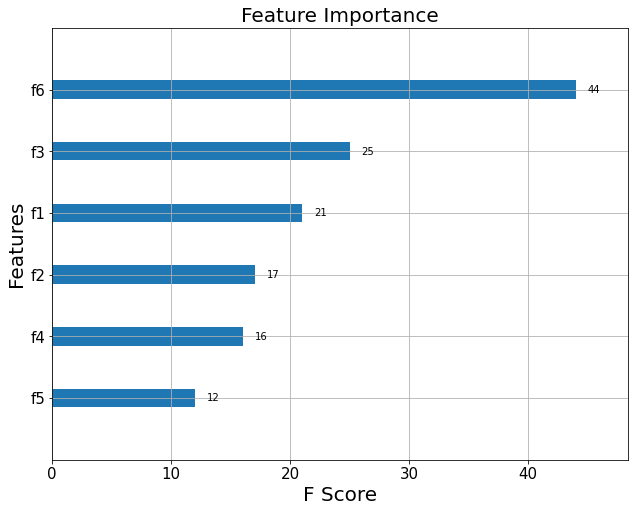

In [ ]:
 plot_importance(xgb, clf)

In [ ]:
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model
# warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
train

,user_id,song_id,frequency
1100960,27104,108685,3
920137,2455,81912,1
851765,18437,36622,2
944086,2697,112296,1
178232,98170,82374,5
...,...,...,...
259178,11323,109642,3
1414414,77360,105995,3
131932,4467,85327,1
671155,43418,132977,1


In [ ]:
n_items = len(pd.unique(data['song_id']))
n_users = len(pd.unique(data['user_id']))

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(n_items+1, 5, name="Movie-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Books")(movie_embedding)
# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)
# concatenate features
conc = Concatenate()([movie_vec, user_vec])
# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)
# Create model and compile it
model2 = Model([user_input, movie_input], out)
model2.compile('adam', 'mean_squared_error')


In [ ]:
history = model2.fit([train.user_id, train.song_id], train.frequency, epochs=5, verbose=1)

Epoch 1/5
36274/36274 [==============================] - 541s 15ms/step - loss: 47.5822
Epoch 2/5
36274/36274 [==============================] - 528s 15ms/step - loss: 44.1185
Epoch 3/5
36274/36274 [==============================] - 530s 15ms/step - loss: 42.4767
Epoch 4/5
36274/36274 [==============================] - 538s 15ms/step - loss: 38.5063
Epoch 5/5
36274/36274 [==============================] - 523s 14ms/step - loss: 38.4402
